In [20]:
import pandas as pd
import geopandas as gpd
import osmnx as ox

from shapely.geometry import Point

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
# define parameters (such as average_speed, ticket_price, etc.) in the default_SUM.json file
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

<h5>Prepare the input data</h5>

In [3]:
# When first time running the code, download and save the city graph:
# inData = ExMAS.utils.download_G(inData, params) # download the graph and compute the skim
# ExMAS.utils.save_G(inData, params) # saves graph to params.paths.G

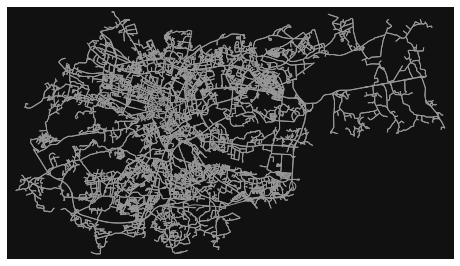

In [21]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)
fig, ax = ox.plot_graph(inData.G, node_size=0)

In [5]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<Axes: >

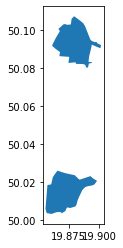

In [6]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326)
gdf_areas.plot()

In [7]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [8]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate "probabilities" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [9]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

<h4>Comparing utilities for 2 areas</h4>

<b>Run the simulations:</b>
<br>For each area generate the sample of requests, containing: origin, destination and time of request (O, D, T)
<br><b>The public transport option (PT):</b>
<ul>
    <li>using the OTP API define the PT routes for each request in the sample (PT OD)</li>
    <li>calculate the utility of each trip (u PT OD)</li>
</ul>
<br><b>The SUM option:</b>
<ul>
    <li>calculate the utility of the trip from origin to hub (u SUM OH)</li>
    <li>with OTP API define the PT routes for each request from the hub to destination (PT HD)</li>
    <li>calculate the utility of the trip from hub to destination (u PT HD)</li>
    <li>calculate the total utility of the SUM option (u SUM OD)</li>
</ul>
<br><b>Results:</b>
<ul>
    <li>Tuple where the 1st element is a dictionary with area name as the key and dataframe as the value
    <br>resulting dataframe contains such parameters: 
    <ul>
        <li>waiting times for the PT OD ('tw_PT_OD') and PT HD ('tw_PT_HD')</li>
        <li>utilities for PT OD ('u_PT_OD') and SUM OD ('u_SUM_OD')</li>
        <li>probability of choosing SUM service ('p_SUM')</li>
    </ul>
    ex.: {'Skotniki': tw_PT_OD, tw_PT_HD, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM}
    </li>
    <li>2nd element of the tuple is a dictionary, where area name is the key and dataframe is the value
    <ul>
        <li>dataframe contains results of the last iteration for the SUM parameters
        <br>ex. {'Skotniki': origin_x, origin_y, destination_x, destination_y, treq, u_PT_OD, origin, hub, dist, ttrav, tarr, u, u_SUM_OD, p_SUM}
        </li>
    </ul>
    </li>
<ul>

In [10]:
# Hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

In [11]:
# Run simulations
N = 1
results = fncs.simulate(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, N)

In [ ]:
# Save results
# results[0]["Bronowice Wielkie"].to_csv("results/bronowice_" + str(N) + ".csv")
# results[1]["Skotniki"].to_csv("results/skotniki_" + str(N) + ".csv")

In [12]:
# example of the results of 1 iteration for the Bronowice Wielkie area
results[0]['Bronowice Wielkie']

,tw_PT_OD,tw_PT_HD,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM
0,90.127983,33.993407,12.511366,8.86326,15.054799,0.305681


In [13]:
df_SUM_bronowice = results[1]["Bronowice Wielkie"]
df_SUM_bronowice.head(2)

,origin_x,origin_y,destination_x,destination_y,treq,u_PT_OD,origin,hub,dist,ttrav,tarr,u,u_SUM_OD,p_SUM
0,19.888808,50.092250,19.934195,50.070585,2024-03-28 07:49:13,11.474733,2486206084,1786358199,2248,374.666667,2024-03-28 07:55:27,4.496,14.721247,0.037452
1,19.888952,50.096458,19.890258,50.091845,2024-03-28 07:53:16,4.152887,51975594,1786358199,2718,453.000000,2024-03-28 08:00:49,5.436,13.938773,0.000056


<h4>ExMAS for SUM areas</h4>

In [14]:
# Bronowice area
bronowice_reqs = results[1]["Bronowice Wielkie"][["origin_x", "origin_y", 
                                                "destination_x", "destination_y", "treq"]]
bronowice_reqs.head(5)

,origin_x,origin_y,destination_x,destination_y,treq
0,19.888808,50.092250,19.934195,50.070585,2024-03-28 07:49:13
1,19.888952,50.096458,19.890258,50.091845,2024-03-28 07:53:16
2,19.880294,50.097711,19.994096,50.067139,2024-03-28 07:55:36
3,19.870623,50.098778,20.002554,50.158685,2024-03-28 08:09:39
4,19.882816,50.098117,19.938498,50.062474,2024-03-28 08:06:51


In [15]:
# Skotniki area
skotniki_reqs = results[1]["Skotniki"][["origin_x", "origin_y", 
                                        "destination_x", "destination_y", "treq"]].reset_index(drop=True)
skotniki_reqs.head(5)

,origin_x,origin_y,destination_x,destination_y,treq
0,19.862751,50.016333,19.938498,50.062474,2024-03-28 07:47:28
1,19.867205,50.016715,19.935630,50.087582,2024-03-28 08:06:48
2,19.873865,50.007897,19.890428,50.011478,2024-03-28 08:01:48
3,19.883339,50.012922,20.021029,50.031812,2024-03-28 08:05:26
4,19.879330,50.023018,19.925828,50.075653,2024-03-28 07:50:01


In [18]:
# Run ExMAS for Skotniki area
fncs.run_ExMAS(skotniki_reqs, inData, params, hubs["Skotniki"], degree=8)

17-06-24 12:43:10-INFO-Initializing pairwise trip shareability between 172 and 172 trips.
17-06-24 12:43:10-INFO-creating combinations
17-06-24 12:43:10-INFO-29412	 nR*(nR-1)
17-06-24 12:43:10-INFO-Reduction of feasible pairs by 99.04%
17-06-24 12:43:10-INFO-Degree 2 	Completed
17-06-24 12:43:10-INFO-trips to extend at degree 2 : 602
17-06-24 12:43:11-INFO-At degree 2 feasible extensions found out of 123 searched
17-06-24 12:43:11-INFO-Degree 3 	Completed
17-06-24 12:43:11-INFO-trips to extend at degree 3 : 123
17-06-24 12:43:11-INFO-At degree 3 feasible extensions found out of 16 searched
17-06-24 12:43:11-INFO-Degree 4 	Completed
17-06-24 12:43:11-INFO-trips to extend at degree 4 : 16
17-06-24 12:43:11-INFO-At degree 4 feasible extensions found out of 0 searched
17-06-24 12:43:11-INFO-Degree 5 	Completed
17-06-24 12:43:11-INFO-No more trips to exted at degree 5
17-06-24 12:43:11-INFO-Matching 172 trips to 913 rides in order to min u_veh
17-06-24 12:43:11-INFO-Problem solution: Optima

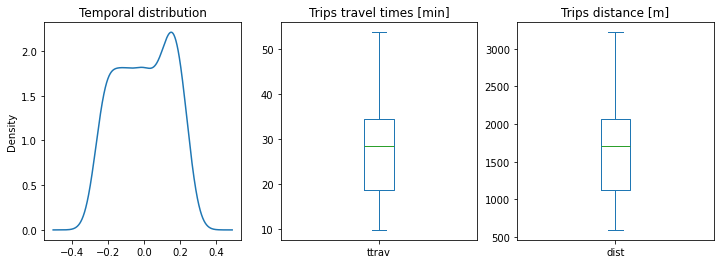

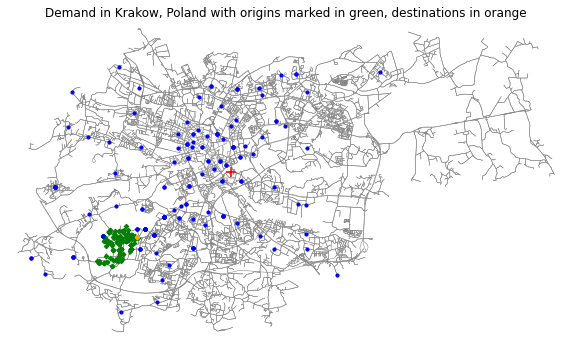

In [19]:
ExMAS.utils.plot_demand(inData, params)

In [16]:
# Run ExMAS for Bronowice Wielkie area
fncs.run_ExMAS(bronowice_reqs, inData, params, hubs["Bronowice Wielkie"], degree=8)

17-06-24 12:29:27-INFO-Initializing pairwise trip shareability between 461 and 461 trips.
17-06-24 12:29:27-INFO-creating combinations
17-06-24 12:29:27-INFO-212060	 nR*(nR-1)
17-06-24 12:29:29-INFO-Reduction of feasible pairs by 98.66%
17-06-24 12:29:29-INFO-Degree 2 	Completed
17-06-24 12:29:29-INFO-trips to extend at degree 2 : 5643
17-06-24 12:29:39-INFO-At degree 2 feasible extensions found out of 8309 searched
17-06-24 12:29:39-INFO-Degree 3 	Completed
17-06-24 12:29:39-INFO-trips to extend at degree 3 : 8309
17-06-24 12:30:04-INFO-At degree 3 feasible extensions found out of 14581 searched
17-06-24 12:30:04-INFO-Degree 4 	Completed
17-06-24 12:30:04-INFO-trips to extend at degree 4 : 14581
17-06-24 12:31:03-INFO-At degree 4 feasible extensions found out of 16346 searched
17-06-24 12:31:04-INFO-Degree 5 	Completed
17-06-24 12:31:04-INFO-trips to extend at degree 5 : 16346
17-06-24 12:32:23-INFO-At degree 5 feasible extensions found out of 11186 searched
17-06-24 12:32:23-INFO-Deg

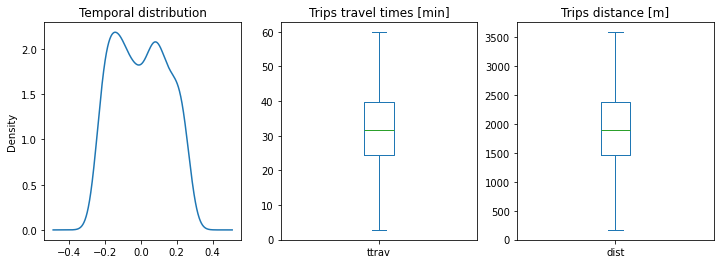

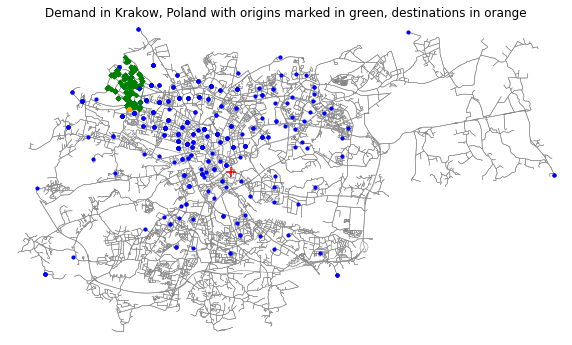

In [17]:
ExMAS.utils.plot_demand(inData, params)